In [ ]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip

--2022-01-09 20:54:55--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640208 (18M) [application/zip]
Saving to: ‘DSL2122_january_dataset.zip’

DSL2122_january_dat 100%[===================>]  17.78M  13.7MB/s    in 1.3s    

2022-01-09 20:54:57 (13.7 MB/s) - ‘DSL2122_january_dataset.zip’ saved [18640208/18640208]



In [ ]:
!unzip DSL2122_january_dataset.zip

Archive:  DSL2122_january_dataset.zip
   creating: DSL2122_january_dataset/
  inflating: DSL2122_january_dataset/development.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._development.csv  
  inflating: DSL2122_january_dataset/sample_submission.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._sample_submission.csv  
  inflating: DSL2122_january_dataset/evaluation.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._evaluation.csv  


In [ ]:
pip install imblearn

In [ ]:
import pandas as pd
import numpy as np

# Matplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, \
 accuracy_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# nltk
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
from nltk.stem.porter import *


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
from bs4 import BeautifulSoup

# Word2vec
import gensim

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 
#nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
df = pd.read_csv('DSL2122_january_dataset/development.csv', index_col=1, encoding='latin-1')
df = df.drop_duplicates()
eval_df = pd.read_csv("DSL2122_january_dataset/evaluation.csv", index_col=0, encoding='latin-1')

In [ ]:
df_merged = pd.concat([df.text, eval_df.text])

# EDA

In [ ]:
df.head()

,sentiment,date,flag,user,text
ids,,,,,
1833972543,1,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1980318193,1,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
1994409198,1,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
1824749377,0,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
2001199113,0,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224994 entries, 1833972543 to 2016018811
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   date       224994 non-null  object
 2   flag       224994 non-null  object
 3   user       224994 non-null  object
 4   text       224994 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


Let's see if there's some imbalancing:

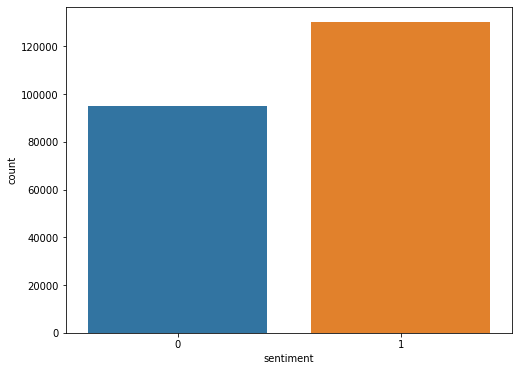

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment',data=df)

# First benchmark:

We'll use only the text as features..

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
X_tfidf.shape

(224994, 156707)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((179995, 156707), (179995,))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.702926731705149
f1 score:  0.7437509584419568


# Preprocessing:

Lemmatization and Stopwords elimination:

In [ ]:
class LemmaTokenizer(object):
  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()


  def __call__(self, document):
    lemmas = []
    for t in word_tokenize(document):
      t = t.strip()
      lemma = self.lemmatizer.lemmatize(t)
      lemmas.append(lemma)
    return lemmas


lemmaTokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer, max_features=100000)
X_tfidf = vectorizer.fit_transform(df.text)

Performances after lemmatization and stopwords elimination:



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(179995, 100000)

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test, average='macro'))

Accuracy:  0.7968621524922777
f1 score:  0.7888454493429038


In [ ]:
y_pred = clf.predict(X_train)
print("Accuracy on train set: ", accuracy_score(y_pred=y_pred, y_true=y_train))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_train, average='macro'))

Accuracy on train set:  0.8319397761048918
f1 score:  0.8254848525660863


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.6928820640458677
f1 score:  0.7392256019322212


Let's try stopword removal only:

you can make a set of stopwords and remove some of the words using the remove function.

stoplist = set(stopwords.words("english")
stoplist.remove('Not').

You can then use this set to filter out the list of stopwords you want.



In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
X_tfidf.shape

(224994, 156563)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((179995, 156563), (179995,))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.7093268739305318
f1 score:  0.7520191104538733


It's clear that lemmatization worsen the performances.. this can happen because abbreviations, like punctuation, can be relevant to sentiment detection.
The problem is that default tokenization used by TfidfVectorizer explicitly ignores all punctuation.

We can modify **token_pattern** in Tfidf_vectorizer to be any character except one or more whitespaces:



In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), token_pattern=r'[^\s]+')
X_tfidf = vectorizer.fit_transform(df.text)
print("Shape after tf-idf: ", X_tfidf.shape)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 263344)
Accuracy:  0.7001488921976043
f1 score:  0.7436594030814827


If we want to modify the hyperparameters of the tf-idf model, we should tune 


1.   Term frequency weighting. Recall that the term frequency is the normalized count of terms in a given document. This value can be set to:
• b - binary,
• t or n - raw,
• a - augmented,
• l - logarithm,
• d - double logarithm,
• L - log average.

2.   Document frequency weighting. Recall that the document frequency is the number of documents in a corpus that contain a given term. This value can be set to:
• x or n - none,
• f - idf,
• t - zero-corrected idf,
• p - probabilistic idf.
3.   Document normalization. Each document is normalized so that all document vectors are turned into unit vectors. In doing so, we eliminate all information on the length of the original document; this masks some subtleties about longer documents. First, longer documents will — as a result of containing more terms — have higher term frequency values. Second, longer documents contain more distinct terms. The document normalization can be set to:
• x or n - none,
• c - cosine,
• u - pivoted unique,
• b - pivoted character length.





#  **Anther** **preprocessing**:

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused',
          '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', 
          ":'-)": 'sadsmile',';)': 'wink',';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopword =  ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do','does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here','hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them','themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre","youve", 'your', 'yours', 'yourself', 'yourselves']

stopword_new =  ['a', 'about', 'above', 'all', 'am', 'an', 'and', 'are', 'at', 'be', 'before',
             'below',  'can', 'd', 'did', 'do','does', 'for', 'from', 
             'had', 'has', 'have', 'he', 'her', 'hers',  'him', 'his', 'how', 'i', 'in',
             'is', 'it', 'its', 'll', 'm', 'ma','me', 'my', 'now', 'o', 'of', 'on',
             'or', 'our', 'ours', 'out', 're','s', 'she', "shes", 'so', 'such',
             't', 'that', "thatll", 'the', 'their', 'theirs', 'them', 'there', 'these', 'they', 'this',
             'to', 'under', 'up', 've', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
             'will', 'with', 'y', 'you', "youd", "youll", "youre" , "youve", 'your', 'yours']

punctuations = \
	[	('__PUNC_EXCL',		['!', '¡', ] )	,
		('__PUNC_QUES',		['?', '¿', ] )	,
		('__PUNC_ELLP',		['...', '…', ] ) ]

# Happy emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3', '=^.^=', '$_$', 'O:-)','(:-D'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', 'O.o', '<(-_-)>',':-$', '@@', ';d', ':-E'
    ])

emoticons = emoticons_happy.union(emoticons_sad)

In [ ]:
for w in stopword:
    if w not in stopwords.words("english"):
        print(w)

shes
shouldve
thatll
youd
youll
youre
youve


In [ ]:
for w in stopwords.words("english"):
    if w not in stopword:
        print(w)

you're
you've
you'll
you'd
she's
it's
that'll
but
against
off
over
no
nor
not
don
don't
should've
aren
aren't
couldn
couldn't
didn
didn't
doesn
doesn't
hadn
hadn't
hasn
hasn't
haven
haven't
isn
isn't
mightn
mightn't
mustn
mustn't
needn
needn't
shan
shan't
shouldn
shouldn't
wasn
wasn't
weren
weren't
won't
wouldn
wouldn't


In [ ]:
def preprocess(text):
    processedText = []
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = r"@"
    alphaPattern      = r"[^a-z\s\(\-:\)\\\/\];='#]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    hashPattern = r"#"
    elongatedPattern = r'(\w*)(\w+)(\2)(\w*)'
    htmlRefPattern = r'&[a-z]+;'
    rptPattern = re.compile(r"(.)\1{1,}", re.IGNORECASE);

    
    for tweet in text:
        soup = BeautifulSoup(tweet, 'lxml')
        tweet = soup.get_text()
        
        tweet = tweet.lower()
        
        # Removing html ref
        # tweet = re.sub(htmlRefPattern, '', tweet)
                                        
        # Replace contractions with regular form
        tweet = tweet.replace(" won't ", ' will not ').replace("n't ", ' not ') \
        .replace("'s ", ' is ').replace("'m ", ' am ') \
        .replace("'ll ", ' will ').replace("'d ", ' would ') \
        .replace("'re ", ' are ').replace("'ve ", ' have ')

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # Replace all emojis.
        for emoji in emojis:
            tweet = tweet.replace(emoji, "EMOJI " + emojis[emoji])  
            
        # Mentions handling: replace '@' with ''.
        tweet = re.sub(userPattern, '', tweet)

        # Handle hashtags
        tweet = re.sub(hashPattern, '', tweet)
        
        #replace consecutive non-ASCII characters with a space
        #tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        
        # Replace 3 or more consecutive letters by 2 repeted words.
        tweet = re.sub(rptPattern, rpt_repl, tweet)
        
        processedText.append(tweet)
    
    return processedText


# For substituting repeating letters into words
def rpt_repl(match):
    return match.group(1)+match.group(1)


# look for word in nltk dictionary
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

In [ ]:
X = preprocess(list(df['text']))
y = df['sentiment']

Here I decided to limit the num of features for tf-idf to 100000 to prevent overfitting, meanwhile I used the reduced stopwords list.

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2)

vect = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)

vect.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

In [ ]:
print("shape after tfidf for train set: ", X_train.shape)
print("shape after tfidf for test set: ", X_test.shape)

shape after tfidf for train set:  (179995, 1000)
shape after tfidf for test set:  (44999, 1000)


Let's try **Logistic Regression**:

In [ ]:
log_clf = LogisticRegression(C = 1, max_iter = 10000, n_jobs=-1)
log_clf.fit(X_train,y_train)

log_pred = log_clf.predict(X_test)
print('Logistic Regression Accuracy :', accuracy_score(y_test,log_pred))
print("f1 score: ", f1_score(y_pred=log_pred, y_true=y_test, average='macro'))

Logistic Regression Accuracy : 0.7653058956865708
f1 score:  0.7556528321356627


In [ ]:
log_pred = log_clf.predict(X_train)
print('Logistic Regression training Accuracy :', accuracy_score(y_train, log_pred))
print("f1 score during training: ", f1_score(y_pred=log_pred, y_true=y_train, average='macro'))

Logistic Regression training Accuracy : 0.7657990499736104
f1 score during training:  0.7562868360199333


NEW BASELINE: contractions, mentions, urls, emojis, 100k features --> **0.832**


WITH Letters repetition handling:
Logistic Regression Accuracy : 0.8010222222222222
f1 score:  0.8290634187316254


WITHOUT Letters repetition handling:
Logistic Regression Accuracy : 0.8008444444444445
f1 score:  0.8289890470556807


WITHOUT Contractions handling: 
Logistic Regression Accuracy : 0.7960888888888888
f1 score:  0.8252323632485143


WITH Punctuation handling:
Logistic Regression Accuracy : 0.7993777777777777
f1 score:  0.827749370373197

WITH html decoding:
Logistic Regression Accuracy : 0.8011111111111111
f1 score:  0.8290092086660809, but way too slower

WITH (1, 3) ngram_range:
Logistic Regression Accuracy : 0.8015555555555556, better accuracy
f1 score:  0.8286448938864795, worse f1 score

Let's try **linearSVC**:

In [ ]:
print("f1 score: ", f1_score(y_svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
pred=y_pred, y_true=y_test))

Accuracy:  0.8016444444444445
f1 score:  0.8280087864657597


**PIPELINE TF-IDF, LOG. REGRESSION:**

In [ ]:
class TweetTokenizer(object):
  def __init__(self):
    self.tokenizer = nltk.tokenize.TweetTokenizer()
    self.stemmer = PorterStemmer()
    

  def __call__(self, document):
    lemmas = []
    for t in self.tokenizer.tokenize(document):
      t = t.strip()
      lemma = self.stemmer.stem(t)
      lemmas.append(lemma)
    return lemmas

tknzr = TweetTokenizer()

In [ ]:
my_df = pd.read_csv('DSL2122_january_dataset/development.csv', index_col=1)
my_df.head()
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)

X = preprocess(list(my_df.text))
y = my_df.sentiment

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.2)
pipe = Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.9, max_features=100000, ngram_range=(1, 3))), ('clf', LogisticRegression(max_iter=1000))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = pipe.predict(X_validation)
print('Valid f1 score: ', f1_score(y_pred=y_pred, y_true=y_validation, average='macro'))
print('Valid accuracay: ', accuracy_score(y_validation, y_pred))

Valid f1 score:  0.7996112383946061
Valid accuracay:  0.8071068245961022


In [ ]:
y_pred_train = pipe.predict(X_train)
print('Training f1 score: ', f1_score(y_pred=y_pred_train, y_true=y_train, average='macro'))
print('Training accuracy: ', accuracy_score(y_train, y_pred_train))

Training f1 score:  0.8517778225285181
Training accuracy:  0.8567793549820828


In [ ]:
gs = GridSearchCV(Pipeline([('tfidf', TfidfVectorizer(max_features=100000, ngram_range=(1, 3))), ('clf', LogisticRegression(max_iter=1000))]),
             param_grid={#'clf__C': [0.1, 1, 10, 100, 1000],
                        #'tfidf__max_features': [50000, 100000, 10000, 1000]},
                        'tfidf__max_df': [0.5, 0.7, 0.90, 1.0],
                        'tfidf__min_df': [1, 2, 3]},
             cv=5,
             scoring='f1_macro',
             refit=True,
             verbose=1)

gs.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=100000,
                                                        ngram_range=(1, 3))),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'tfidf__max_df': [0.5, 0.7, 0.9, 1.0],
                         'tfidf__min_df': [1, 2, 3]},
             scoring='f1_macro', verbose=1)

In [ ]:
gs.best_score_

0.8009658957995216

# Yet another preprocessing:

In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    #words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['text'].iloc[0])
print("\nProcessed tweet ->", tweet_to_words(df['text'].iloc[0]))


Original tweet -> @MissBianca76 Yes, talking helps a lot.. going through it, there's no judgment... most sentences end with &quot;you know what I mean&quot; 

Processed tweet -> ['missbianca76', 'ye', 'talk', 'help', 'a', 'lot', 'go', 'through', 'it', 'there', 's', 'no', 'judgment', 'most', 'sentenc', 'end', 'with', 'quot', 'you', 'know', 'what', 'i', 'mean', 'quot']


In [ ]:
#X = list(map(tweet_to_words, df['text']))
y = df.sentiment
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 100000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
                               ngram_range=(1,3),    # unigram and bigram
                               preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train)

# Transform testing data
X_validation = count_vector.transform(X_validation)

In [ ]:
SEED = 2000
clf = LogisticRegression(C=1, max_iter=5000)
clf.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000)

In [ ]:
y_pred = clf.predict(X_validation)
print('Valid f1 score: ', f1_score(y_pred=y_pred, y_true=y_validation, average='macro'))
print('Valid accuracay: ', accuracy_score(y_validation, y_pred))
y_pred_train = clf.predict(X_train)
print('Training f1 score: ', f1_score(y_pred=y_pred_train, y_true=y_train, average='macro'))
print('Training accuracy: ', accuracy_score(y_train, y_pred_train))

Valid f1 score:  0.7925895368043988
Valid accuracay:  0.799439987555279


Training f1 score:  0.9275991065800231
Training accuracy:  0.929759159976666


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 100000
max_len = 50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['text'].iloc[0])
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 @MissBianca76 Yes, talking helps a lot.. going through it, there's no judgment... most sentences end with &quot;you know what I mean&quot; 
After Tokenization & Padding 
 [30207   123   481  1337     4   298    62   427     7   431    37 40209
   349 10088   417    27    42     5    47    48     1   307    42     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [ ]:
y = df['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
#print('Test Set ->', X_test.shape, y_test.shape)


Train Set -> (202494, 50) (202494,)
Validation Set -> (22500, 50) (22500,)


NameError: ignored

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


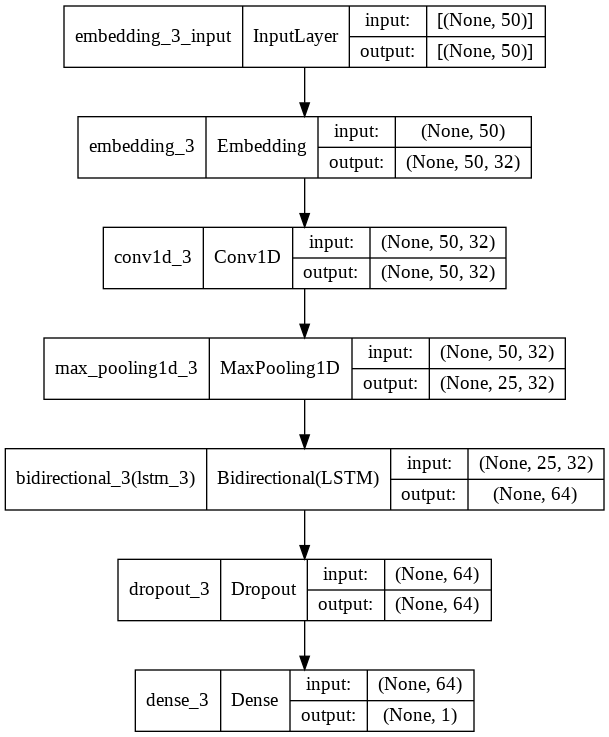

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', 
               metrics=['accuracy', f1])

# Train model

history = model.fit(X_train, y_train, batch_size=64,
                      validation_data=(X_val, y_val),
                      epochs=5, verbose=1)

Epoch 1/5
3164/3164 [==============================] - 64s 19ms/step - loss: 0.4649 - accuracy: 0.7762 - f1: 0.8088 - val_loss: 0.4367 - val_accuracy: 0.7942 - val_f1: 0.8200
Epoch 2/5
3164/3164 [==============================] - 59s 19ms/step - loss: 0.4143 - accuracy: 0.8079 - f1: 0.8334 - val_loss: 0.4263 - val_accuracy: 0.7973 - val_f1: 0.8257
Epoch 3/5
3164/3164 [==============================] - 59s 19ms/step - loss: 0.3885 - accuracy: 0.8217 - f1: 0.8455 - val_loss: 0.4278 - val_accuracy: 0.7972 - val_f1: 0.8249
Epoch 4/5
3164/3164 [==============================] - 59s 19ms/step - loss: 0.3643 - accuracy: 0.8357 - f1: 0.8575 - val_loss: 0.4436 - val_accuracy: 0.7944 - val_f1: 0.8282
Epoch 5/5
3164/3164 [==============================] - 59s 19ms/step - loss: 0.3400 - accuracy: 0.8493 - f1: 0.8690 - val_loss: 0.4611 - val_accuracy: 0.7921 - val_f1: 0.8162


In [ ]:
# Evaluate model on the test set
loss, accuracy, f1 = model.evaluate(X_val, y_val, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))


Accuracy  : 0.7921


In [ ]:
SEED = 2000
clf = LogisticRegression(C=1, max_iter=5000)
clf.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000)

In [ ]:
y_pred = clf.predict(X_val)
print('Valid f1 score: ', f1_score(y_pred=y_pred, y_true=y_val, average='macro'))
print('Valid accuracay: ', accuracy_score(y_val, y_pred))
y_pred_train = clf.predict(X_train)
print('Training f1 score: ', f1_score(y_pred=y_pred_train, y_true=y_train, average='macro'))
print('Training accuracy: ', accuracy_score(y_train, y_pred_train))

Valid f1 score:  0.38368072916649054
Valid accuracay:  0.5787111111111111
Training f1 score:  0.3831714311674207
Training accuracy:  0.5796171738421879


In [ ]:
X_train.shape

(202494, 50)

# Preprocessing basic approach:

In [ ]:
from nltk.tokenize import WordPunctTokenizer, TweetTokenizer
import string

tweets_dev = df.text
tweets_eval = eval_df.text

# Punctuation set
punctuation = []
for p in string.punctuation:
  if p not in ['!', '?', '#', '@']:
    punctuation.append(p)
punctuation.append('�')

urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
rptPattern = re.compile(r"(.)\1{1,}", re.IGNORECASE);


def tweet_cleaner(text):
  urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  rptPattern = re.compile(r"(.)\1{1,}", re.IGNORECASE);

  soup = BeautifulSoup(text, 'lxml')
  tweet = soup.get_text().encode('latin1').decode('utf-8')

  try:
    tweet = tweet.encode('latin1').decode('utf-8')
  except:
    pass

  tweet.lower()

  #tweet = tweet.replace('�', "'")

  # remove numbers
  #text_nonum = re.sub(r'\d+', '', text)
  #remove punctuations (# , @ included)
  #tweet = "".join([char for char in tweet if char not in punctuation]) 
  #replace consecutive non-ASCII characters with a space
  #tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

  tweet = re.sub(r'@', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  tweet = re.sub(urlPattern, ' URL', tweet)
  tweet = re.sub(rptPattern, rpt_repl, tweet)
  
  return tweet



# For substituting repeating letters into words
def rpt_repl(match):
    return match.group(1)+match.group(1)


cleaned_tweets_dev = [tweet_cleaner(t) for t in list(tweets_dev)]
cleaned_tweets_eval = [tweet_cleaner(t) for t in list(tweets_eval)]
cleaned_tweets_merged = cleaned_tweets_dev + cleaned_tweets_eval

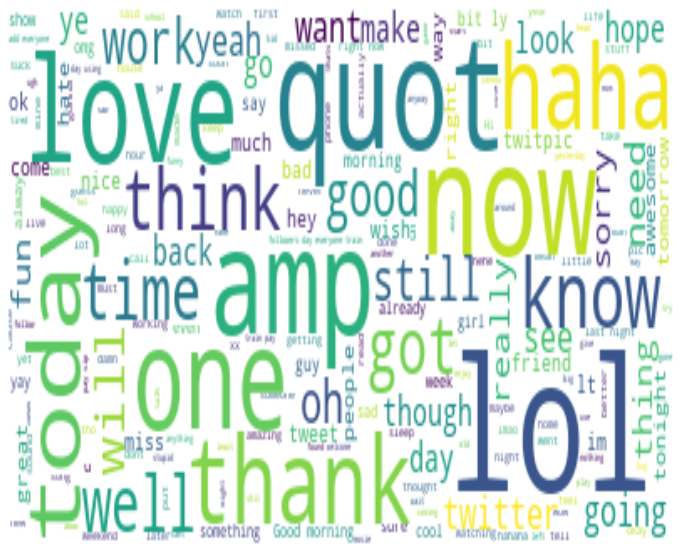

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(tweet for tweet in df.text)

wordcloud = WordCloud(stopwords=None, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.rcParams["figure.figsize"] = (12,10)
plt.show()

In [ ]:
cleaned_tweets_merged

In [ ]:
class Tokenizer(object):
  def __init__(self):
    self.tokenizer = WordPunctTokenizer()


  def __call__(self, document):
    return self.tokenizer.tokenize(document)


tknzr = Tokenizer()

In [ ]:
vectorizer = TfidfVectorizer(max_features=70000, ngram_range=(1, 3), tokenizer=tknzr)
vectorizer.fit(cleaned_tweets_merged)
X = vectorizer.transform(cleaned_tweets_dev)
X_train, X_test, y_train, y_test = train_test_split(X, df.sentiment, test_size=0.2)

log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test, average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Accuracy:  0.8062006889654406
f1 score:  0.7994807441936622


In [ ]:
y_pred = log_clf.predict(X_train)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_train))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_train, average='macro'))

Accuracy:  0.8539027425879006
f1 score:  0.8486612499012753


BASELINE Basics 70000 features: Accuracy:  0.8111069134869664
f1 score:  0.8042111634881122

TweetTokenizer: f1 score:  0.8017099656909327



---




In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLP(max_iter=10, early_stopping=True)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test, average='macro'))

In [ ]:
y_pred = mlp.predict(X_train)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_train))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_train, average='macro'))

Accuracy:  0.8735798216617128
f1 score:  0.8696362370124051


In [ ]:
from sklearn.svm import SVC

svm = SVC(verbose=True)
svm.fit(X_train[:100000], y_train[:100000])
y_pred = svm.predict(X_test[:10000])
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test[:10000]))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test[:10000], average='macro'))

[LibSVM]

# Dealing with class imbalance:

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
lr = LogisticRegression(max_iter = 1000, n_jobs=-1)

In [ ]:

def lr_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X.iloc[train], Y.iloc[train])
        prediction = lr_fit.predict(X.iloc[test])
        scores = lr_fit.score(X.iloc[test],Y.iloc[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y.iloc[test], prediction, average=average_method)*100)
        print('              negative         positive')
        print('precision:', precision_score(Y.iloc[test], prediction, average=None))
        recall.append(recall_score(Y.iloc[test], prediction, average=average_method)*100)
        print('recall:   ', recall_score(Y.iloc[test], prediction, average=None))
        f1.append(f1_score(Y.iloc[test], prediction, average=average_method)*100)
        print('f1 score: ', f1_score(Y.iloc[test], prediction, average=None))
        print('-' * 50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


In [ ]:
original_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', lr)
])

lr_cv(5, df.text, df.sentiment, original_pipeline, 'macro')


              negative         positive
precision: [0.76599882 0.78707767]
recall:    [0.68534824 0.84745698]
f1 score:  [0.72343267 0.81615212]
--------------------------------------------------
              negative         positive
precision: [0.7706012 0.7861497]
recall:    [0.68186851 0.8521051 ]
f1 score:  [0.72352448 0.81779973]
--------------------------------------------------
              negative         positive
precision: [0.76644502 0.78483395]
recall:    [0.68061999 0.8488725 ]
f1 score:  [0.72098738 0.81559812]
--------------------------------------------------
              negative         positive
precision: [0.76606153 0.78700103]
recall:    [0.68520666 0.84752795]
f1 score:  [0.72338176 0.81614383]
--------------------------------------------------
              negative         positive
precision: [0.76115006 0.78419269]
recall:    [0.68113038 0.84426261]
f1 score:  [0.71892042 0.81311973]
--------------------------------------------------
accuracy: 77.84% (+/- 

We can see that the recall for the negative class is quite low, while the precisions for the negative class are high as. This means the classifier is very picky and does not think many things are negative. All the text it classifies as negative is ~68% of the time really negative.

In [ ]:
#SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=42), lr)
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
testing_tfidf = vectorizer.fit_transform(df.text)

smt = SMOTE(random_state=42, sampling_strategy=1, k_neighbors=1, n_jobs=-1)
X_SMOTE, y_SMOTE = smt.fit_resample(testing_tfidf, df.sentiment)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,y_SMOTE, test_size=0.1, random_state=42)

#smt_df = pd.DataFrame(X_SMOTE.todense(), columns=vectorizer.get_feature_names())

/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [ ]:
X_SMOTE.shape

(247298, 156563)

In [ ]:
X_train.shape

(202494, 156563)

In [ ]:
log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


Accuracy:  0.7865345733926405
f1 score:  0.7973123440199653


In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_resample(testing_tfidf, df.sentiment)
print(X_ROS.shape)

X_train, X_test, y_train, y_test = train_test_split(X_ROS, y_ROS, test_size=0.1, random_state=42)


log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


(260314, 156563)
Accuracy:  0.7884910878918254
f1 score:  0.7907100501748517


In [ ]:
GridSearchCV_pipeline = make_pipeline(vectorizer, SMOTE(random_state=42, sampling_strategy=1, k_neighbors=1, n_jobs=-1), lr)
lr_cv(5, df.text, df.sentiment, SMOTE_pipeline, 'macro')

It is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling:

In [ ]:
# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = df.text, df.sentiment
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = LogisticRegression(max_iter = 5000, n_jobs=-1)
	over = SMOTE(sampling_strategy=0.9, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.9)
	steps = [('tfidf', vectorizer), ('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
	scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, F1 score: %.3f' % (k, score))

> k=1, F1 score: 0.768
> k=2, F1 score: 0.768
> k=3, F1 score: 0.768
> k=4, F1 score: 0.768
> k=5, F1 score: 0.768
> k=6, F1 score: 0.768


KeyboardInterrupt: 

# Deep Learning Techniques for Sentiment Analysis

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, TextVectorization
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.python.client import device_lib


In [ ]:
(print(tf. __version__))

2.7.0


In [ ]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 870527826346417540
xla_global_id: -1
]


In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.compat.v1.keras.backend.set_session(sess)

Device mapping: no known devices.


Before I feed the data and train the model, I need to deal with one more thing. Keras NN model cannot handle sparse matrix directly. The data has to be dense array or matrix, but transforming the whole training data Tfidf vectors of 1.5 million to dense array won't fit into my RAM. So I had to define a function, which generates iterable generator object so that it can be fed to NN model. Note that the output should be a generator class object rather than arrays, this can be achieved by using "yield" instead of "return".

In [ ]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    n_batches = samples_per_epoch/batch_size
    b_counter=0 # batch counter
    index = np.arange(np.shape(y_data)[0]) # evenly spaced values within an interval
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*b_counter:batch_size*(b_counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        b_counter += 1
        yield np.array(X_batch), np.array(y_batch)
        if (b_counter > n_batches):
            np.random.shuffle(index)
            b_counter=0

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=100000))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.1)
redOnPlat = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

In [ ]:
model.fit_generator(generator=batch_generator(X_train, y_train, 32),\
                    epochs=2, validation_data=(, y_test),\
                    steps_per_epoch=int(X_train.shape[0]/32), callbacks=[redOnPlat])

Let's try sentiment analyisis with RNN:

In [ ]:
tweets_text = preprocess(list(df['text']))
tweets_labels = df.pop('sentiment')

In [ ]:
tweets_text_train, tweets_text_test, tweets_labels_train, tweets_labels_test = train_test_split(tweets_text, tweets_labels, test_size=0.2, random_state=42)

In [ ]:
tweets_labels_train, tweets_labels_test = \
tweets_labels_train.astype(dtype='int8'), \
tweets_labels_test.astype(dtype='int8')

In [ ]:
tweets_train_ds = tf.data.Dataset.from_tensor_slices((tweets_text_train, tweets_labels_train))
tweets_test_ds = tf.data.Dataset.from_tensor_slices((tweets_text_test, tweets_labels_test))

In [ ]:
encoder = TextVectorization(
    max_tokens=100000)
encoder.adapt(tweets_train_ds.map(lambda text, label: text)) # tf-idf vectorizer fit

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return encoder(text), label

train_dataset = tweets_train_ds.map(vectorize_text)
test_dataset = tweets_test_ds.map(vectorize_text)

In [ ]:
tweets_train_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int8)>

In [ ]:
train_dataset = train_dataset.map(lambda tfidf, l: (tf.cast(tfidf, dtype='float16'), tf.expand_dims(tf.cast(l, dtype='int8'), axis=0)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda tfidf, l: (tf.cast(tfidf, dtype='float16'), tf.expand_dims(tf.cast(l, dtype='int8'), axis=0)), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
test_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int8)>

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = tweets_train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tweets_test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int8)>

The limited vocabulary size and lack of character-based fallback results in some unknown tokens.


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    #tf.keras.layers.Dense(64, ac)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=False)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy', f1])

In [ ]:
def scheduler(epoch, lr):
    if epoch in range(1, 11, 2):
        return lr * tf.math.exp(-0.1)
    else:
        return lr

#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=20, verbose=1,
                    callbacks=[ReduceLROnPlateau(patience=2, factor=0.1, monitor='val_loss', mode='min'),
                               EarlyStopping(patience=3, monitor='val_loss', mode='min')])
# epoca 8 è inizio 

2813/2813 [==============================] - 124s 41ms/step - loss: 0.4535 - accuracy: 0.7825 - f1: 0.8126 - val_loss: 0.4332 - val_accuracy: 0.8000 - val_f1: 0.8338 - lr: 0.0010


In [ ]:
y_prob = model.predict(data for data, label in test_dataset) 
y_classes = y_prob.argmax(axis=-1)

In [ ]:
for e in y_classes:
    print(e)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
for data, label in test_dataset:
    print(data)
    break

tf.Tensor(
[b'im on gs bye bye luv ya lots!  xx ~amyluvsandy~'
 b'barelyseeatall oh himm! i do not know much about ff! not much of a gamer at all. '
 b'anightintoronto yeah lmfao i heard it does not work in cold weather too and i live in canada so lol wat is the point..:&lt; i love my curve '
 b'alyssa_milano hope you had a great dinner..happy for you and congrats '
 b'baby, you will get a b, your smart enough too  i love you xx'
 b'about to read and listen to music..while txting! i need to clear my head..badly!!  '
 b'mamacitaa_ as if it is not me?!?!!?! that is a bad call kid! i take pride in my twiter game '
 b'her lisp is driving me insane  especially because she ca not say lilith'
 b'ihustle8o8 i am sure in time you will find  some '
 b'bb517 hiya bb sorry on the phone '
 b'themediapod please send steve my regards!  glad to hear you are using my book  thanks.'
 b"officialas and if people dont remember..they will once they see my awesome vid for you  maybe i will make you a b'day c

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, None, 64)          6400000   
                                                                 
 bidirectional_18 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 32)              

# Submission

In [ ]:
 = eval_dfpd.read_csv("DSL2122_january_dataset/evaluation.csv")
#X_eval = preprocess(list(eval_df.text))

Eval vectorizer and clf:

In [ ]:
X_eval_tfidf = vectorizer.transform(cleaned_tweets_eval)

In [ ]:
y_eval = log_clf.predict(X_eval_tfidf)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("eval_292129.csv", index_label="Id", header=["Predicted"])
print("File written....")

File written....


Eval with pipeline:

In [ ]:
y_eval = pipe.predict(X_eval)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("eval_292129.csv", index_label="Id", header=["Predicted"])
print("File written....")

File written....


Eval with NN:

In [ ]:
y_prob = model.predict(X_eval) 


In [ ]:
y_labels = (y_prob > 0.5).astype(np.int)

In [ ]:
y_labels.reshape((74999)).tolist()

[0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,


In [ ]:
submit = pd.Series(y_labels.reshape((74999)).tolist(), range(len(X_eval)))


In [ ]:
submit.to_csv("eval_292129.csv", index_label="Id", header=["Predicted"])
